here an exact simulation of the system is done. actually is not exact, it's good only for high dephasing conditions.
$$
\dot{V} = \sum_k \Gamma_k [ \sigma_k^+ - (1-n_k) ] V + \sum_k (\Gamma_k+\Gamma_{ry}) [ \sigma_k^- -n_k ] V
$$

In [1]:
import numpy as np
from scipy.spatial import KDTree
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from rydbperc2 import ryperc2

In [2]:
def truncated_normal(mean=0, sd=1, low=0, upp=1):
    """ 
    retruns a truncated normal distribution.
    args:
        mean (float): mean
        sd (float): standard deviation
        low (float): lower bound
        upp (float): upper bound
    returns:
        scipy.stats.truncnorm object
    """
    return truncnorm((low - mean)/sd, (upp - mean)/sd, loc=mean, scale=sd)

class ideal_cluster3D:
    def __init__(self, size, shape=[1,1,1], distribution="uniform", MOT_radius=None, is_2D = False) -> None:
        self.size = size
        self.shape = shape
        self.distribution = distribution
        self.is_2D = is_2D
        if distribution == "gaussian": 
            if MOT_radius == None or MOT_radius <= 0:
                print("\"MOT_radius\" must be a positive float.")
                raise
            self.MOT_radius = MOT_radius
        self.KDT = self.get_KDT()
        self.magnetization_vector_ = magnetization_vector(size)
        pass

    def get_KDT(self):
        """ 
        generates the point positions and creates the KDtree.
        """
        if self.distribution == "uniform":
            positions = np.array([
                                np.random.random(self.size)*self.shape[0]-self.shape[0]/2, 
                                np.random.random(self.size)*self.shape[1]-self.shape[1]/2, 
                                np.random.random(self.size)*self.shape[2]-self.shape[2]/2 if self.is_2D==False else np.zeros(self.size)
                                ], dtype=object)
        elif self.distribution == "gaussian":
            positions = np.array([
                                truncated_normal(0, self.MOT_radius, -self.shape[0]/2, self.shape[0]/2).rvs(self.size), 
                                truncated_normal(0, self.MOT_radius, -self.shape[1]/2, self.shape[1]/2).rvs(self.size), 
                                truncated_normal(0, self.MOT_radius, -self.shape[2]/2, self.shape[2]/2).rvs(self.size) if self.is_2D==False else np.zeros(self.size)
                                ], dtype=object)
        else: 
            print("distribution must be \"uniform\" or \"gaussian\".")
            raise
        return KDTree(positions.T)

    def projector(self, a,b):
        projector_ = np.zeros([2, 2])
        projector_[a,b] = 1
        return projector_

    def sigma(self, pom, k):
        if pom==0:
            a=1
            b=1
        elif pom==-1:
            a=0
            b=1
        elif pom==1:
            a=1
            b=0

        if k == 0:
            _sigma = np.kron(self.projector(a, b), np.eye(2**(self.size-1)))
            return _sigma
        elif k == self.size-1:
            _sigma = np.kron(np.eye(2**(self.size-1)), self.projector(a, b))
            return _sigma
        _sigma = np.eye(2)
        for kk in range(1, self.size):
            if kk == k:
                _sigma = np.kron(_sigma, self.projector(a, b))
            else:
                _sigma = np.kron(_sigma, np.eye(2))
        return _sigma

    def distance(self, i, j):   
        return ((self.KDT.data[i,0] - self.KDT.data[j,0])**2 + (self.KDT.data[i,1] - self.KDT.data[j,1])**2 + (self.KDT.data[i,2] - self.KDT.data[j,2])**2)**(1/2)
        
    def gamma_k(self, k, v):
        potential_term = 0
        for g in range(self.size):
            if g != k:
                potential_term += (C6/self.distance(g,k)**6)*np.sum(np.dot(self.sigma(0, g), v))
        rate = ((omega_rabi/2)**2)*dephasing/((dephasing/2)**2 + (-detuning+potential_term)**2)
        return rate

    def dot_v(self, t, v):
        final_vector = np.zeros(2**self.size)
        for k in range(self.size):
            gam = self.gamma_k(k, v)
            final_vector += gam * np.dot(self.sigma(+1, k) - (np.eye(2**self.size) - self.sigma(0, k)), v)
            final_vector += (gam+gam_ry) * np.dot(self.sigma(-1, k) - self.sigma(0, k), v)
        return final_vector
    
    def get_population_evo(self, ivp_sol):
        populations = np.zeros(len(ivp_sol.t))
        for t in range(len(ivp_sol.t)):
            populations[t] = np.sum(np.dot(self.magnetization_vector_, ivp_sol.y[:,t]))/self.size
        return populations

    def evolve(self, time, steps, initial_state):
        sol = solve_ivp(self.dot_v, [0,time], initial_state, t_eval=np.linspace(0, time, steps))
        population_evo = self.get_population_evo(sol)
        return np.linspace(0, time, steps), population_evo
    
    def show(self):
        """
        shows the 3D cluster
        """
        if self.is_2D == True:
            self.show2D()
            return
        plt.figure(figsize=(15,12))
        ax = plt.axes(projection ="3d")
        ax.scatter(self.KDT.data[:,0],self.KDT.data[:,1],self.KDT.data[:,2], marker=".", c="b",  alpha=1, s=10)
        plt.show()
        return
    
    def show2D(self):
        plt.figure(figsize=(10,10))
        ax = plt.gca()
        ax.plot(self.KDT.data[:,0],self.KDT.data[:,1], linestyle="", marker=".", c="b",  alpha=1)
        plt.show()
        return
    
def magnetization_vector(size):
    output = np.zeros(2**size)
    for num in range(2**size):
        output[num] = magnetization(num, size)
    return output

def magnetization(num, size):
    mag = 0
    for dividend in range(size):
        if num == 0:
            return mag
        if num % 2 == 1:
            mag += 1
        num = num // 2
    return mag


In [70]:
N_atoms = 9
omega_rabi = 0.2 # MHz
dephasing = 8 # MHz
detuning = 20 # MHz
C6 = 870 * 10**3 # MHz*um^6
gam_ry = 0.001
shape = [4,4,4]

In [71]:
reps = 1
time = 10
evos_id = []
evos = []
for _ in range(reps):
    clu_id = ideal_cluster3D(N_atoms, shape = shape)
    clu = ryperc2.cluster3D(N_atoms, shape = shape)
    vector = np.zeros(2**N_atoms)
    vector[0] = 1
    times_id, pop_evo_id = clu_id.evolve(time, 10, vector)
    clu.set_evolution_parameters(
        omega_rabi,
        dephasing,
        detuning,
        C6,
        gam_ry
    )
    pop_evo, __ = clu.evolve(time, 10000)
    times = np.linspace(0,time,10000)
    evos_id.append(pop_evo_id)
    evos.append(pop_evo)
    clear_output(wait=True)
    print(_)

mean_evos = np.mean(evos, axis=0)    
mean_evos_id = np.mean(evos_id, axis=0)    

0


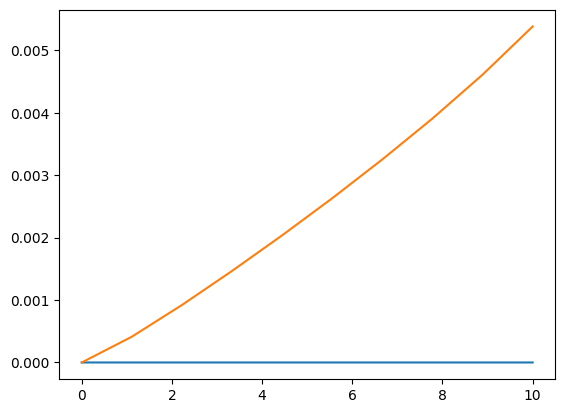

In [72]:
plt.plot(times, mean_evos)
plt.plot(times_id, mean_evos_id)
plt.show()

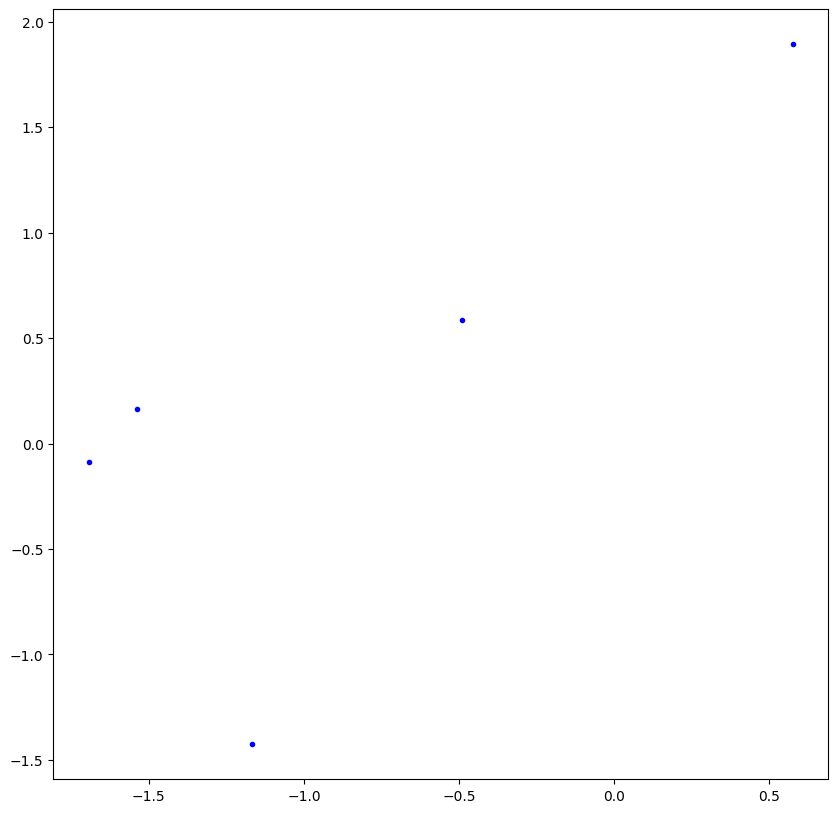

In [6]:
clu.show2D()